In [37]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from datetime import datetime as dt
from dateutil.parser import parse
import re

In [38]:
# we only want the interval data from a single agency
# other ones for NM:  32000-2, 32000-3, 32000-901, 32000-4, 32000-61, 32000-8, 32000-9, 32000-18
agency = "32000-8"
# read the file in chunks, then append only the data that matches that agency
print(dt.now())
iter_csv = pd.read_csv('data/intervals.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['uniquename'] == agency] for chunk in iter_csv])
print(dt.now())

2019-01-30 18:17:47.261940
2019-01-30 18:18:04.042151


In [39]:
# add a new column which is the timestamp as a datetime object
df['ts'] = df.apply(lambda row: parse(row.timestamp), axis=1)

In [40]:
# add a new column for the hour of the day
df['HR'] = df.apply(lambda row: row.ts.hour, axis=1)

In [41]:
# add a new column for the day of the week
df['DOW'] = df.apply(lambda row: row.ts.weekday(), axis=1)

In [42]:
# this function will return a 'code' for (W)eekend, (N)ight, or (D)ay
def timeslot(h,d):
    # h - hour of day
    # d - day of week (0=Monday)
    if d > 4:             # day 5 or 6 (saturday or sunday)
        return "W"        # then Weekend
    elif h < 8 or h > 17: # before 7:59a or after 5:59p 
        return "N"        # then Night
    else:                 # otherwise
        return "D"        # Day

In [43]:
# make a new column with the timeslot code in it
df['SLOT'] = df.apply(lambda row: timeslot(row.HR, row.DOW), axis=1)

In [44]:
print("{} records for agency: {}".format(len(df), agency))
print("first 5:")
df.head()

6698 records for agency: 32000-8
first 5:


,Unnamed: 0,interval,origindex,timestamp,uniquename,ts,HR,DOW,SLOT
2452958,2452958,2492.0,1607271.0,2018-10-11 19:02:33,32000-8,2018-10-11 19:02:33,19,3,N
2452959,2452959,1038.0,1607988.0,2018-10-11 19:19:51,32000-8,2018-10-11 19:19:51,19,3,N
2452960,2452960,413.0,1608271.0,2018-10-11 19:26:44,32000-8,2018-10-11 19:26:44,19,3,N
2452961,2452961,63.0,1608315.0,2018-10-11 19:27:47,32000-8,2018-10-11 19:27:47,19,3,N
2452962,2452962,379.0,1608559.0,2018-10-11 19:34:06,32000-8,2018-10-11 19:34:06,19,3,N


In [45]:
# this removes the rows considered to be 'outliers'
trimmed = df[df.interval < 5000]

In [46]:
# set the # of bins
bins_to_use = 100

In [47]:
# set the groupby using the timeslot
by_slot = trimmed.groupby('SLOT')

<IPython.core.display.Javascript object>


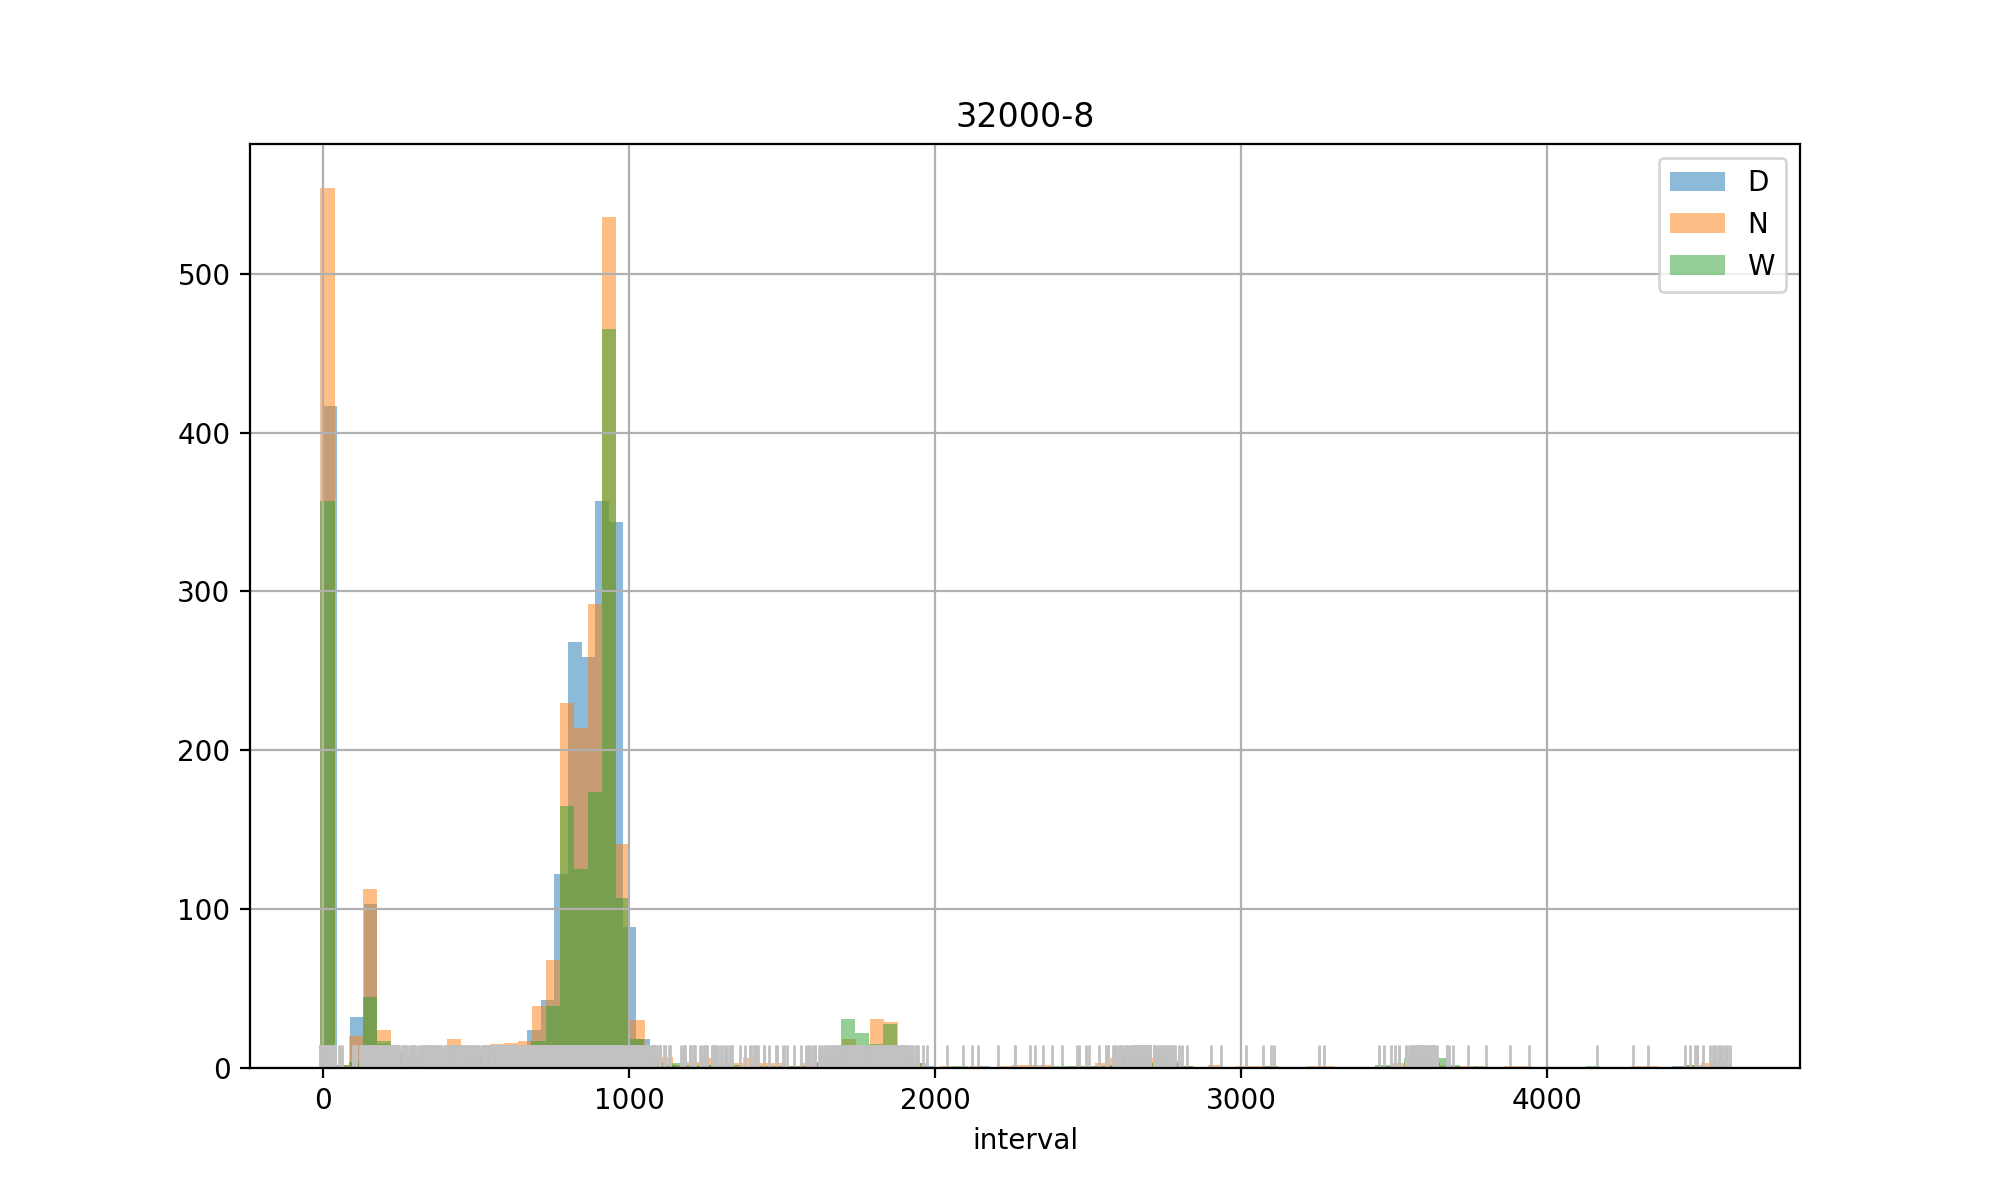

D count    2213.00
mean      706.98
std       467.24
min         0.00
25%       181.00
50%       856.00
75%       933.00
max      4451.00
Name: interval, dtype: object
N count    2637.00
mean      759.12
std       638.68
min        -8.00
25%       153.00
50%       852.00
75%       932.00
max      4596.00
Name: interval, dtype: object
W count    1818.00
mean      833.25
std       684.04
min        -8.00
25%       466.50
50%       889.50
75%       943.00
max      4588.00
Name: interval, dtype: object


In [48]:
# show all the slots in one plot
fig = plt.figure()
ax = plt.subplot()
ax.grid(True, which='both')  # set a grid
fig.set_size_inches(10, 6)   # size of the full figure
rugkws={"height": .025, "color": "999999"}  # rug display parameters
histkws={"linewidth": 1, "alpha": 0.5}        # histogram display parameters

for name, group in by_slot:
    sns.distplot(group.interval, label=name, kde=False, bins=bins_to_use, hist_kws=histkws, rug=True, rug_kws=rugkws)
    # print the basic stats
    print(name, group["interval"].describe().apply(lambda x: format(x, '.2f')))

plt.title(agency)    # output the title
plt.legend()         # display a legend

<IPython.core.display.Javascript object>


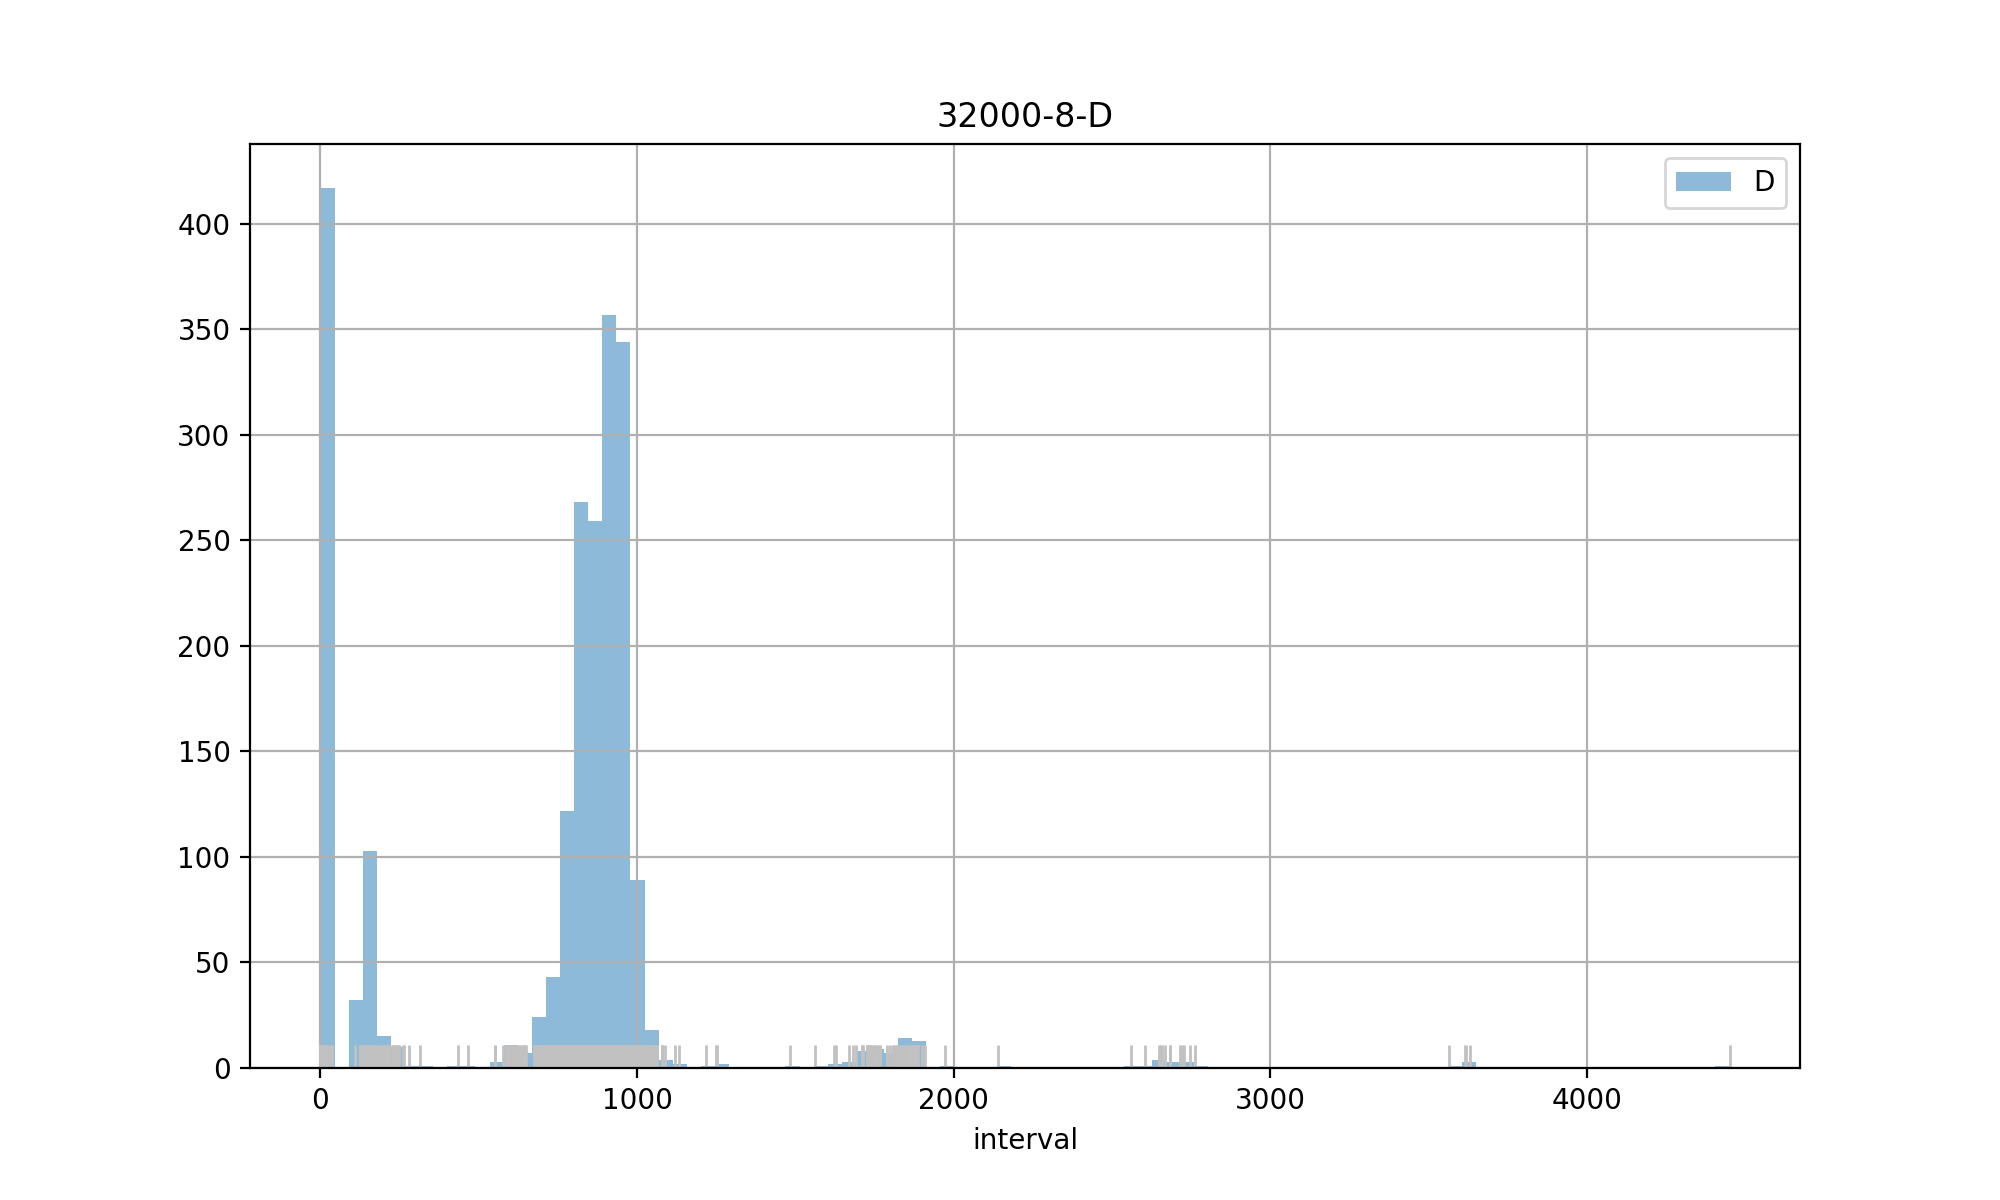

D count    2213.00
mean      706.98
std       467.24
min         0.00
25%       181.00
50%       856.00
75%       933.00
max      4451.00
Name: interval, dtype: object


<IPython.core.display.Javascript object>


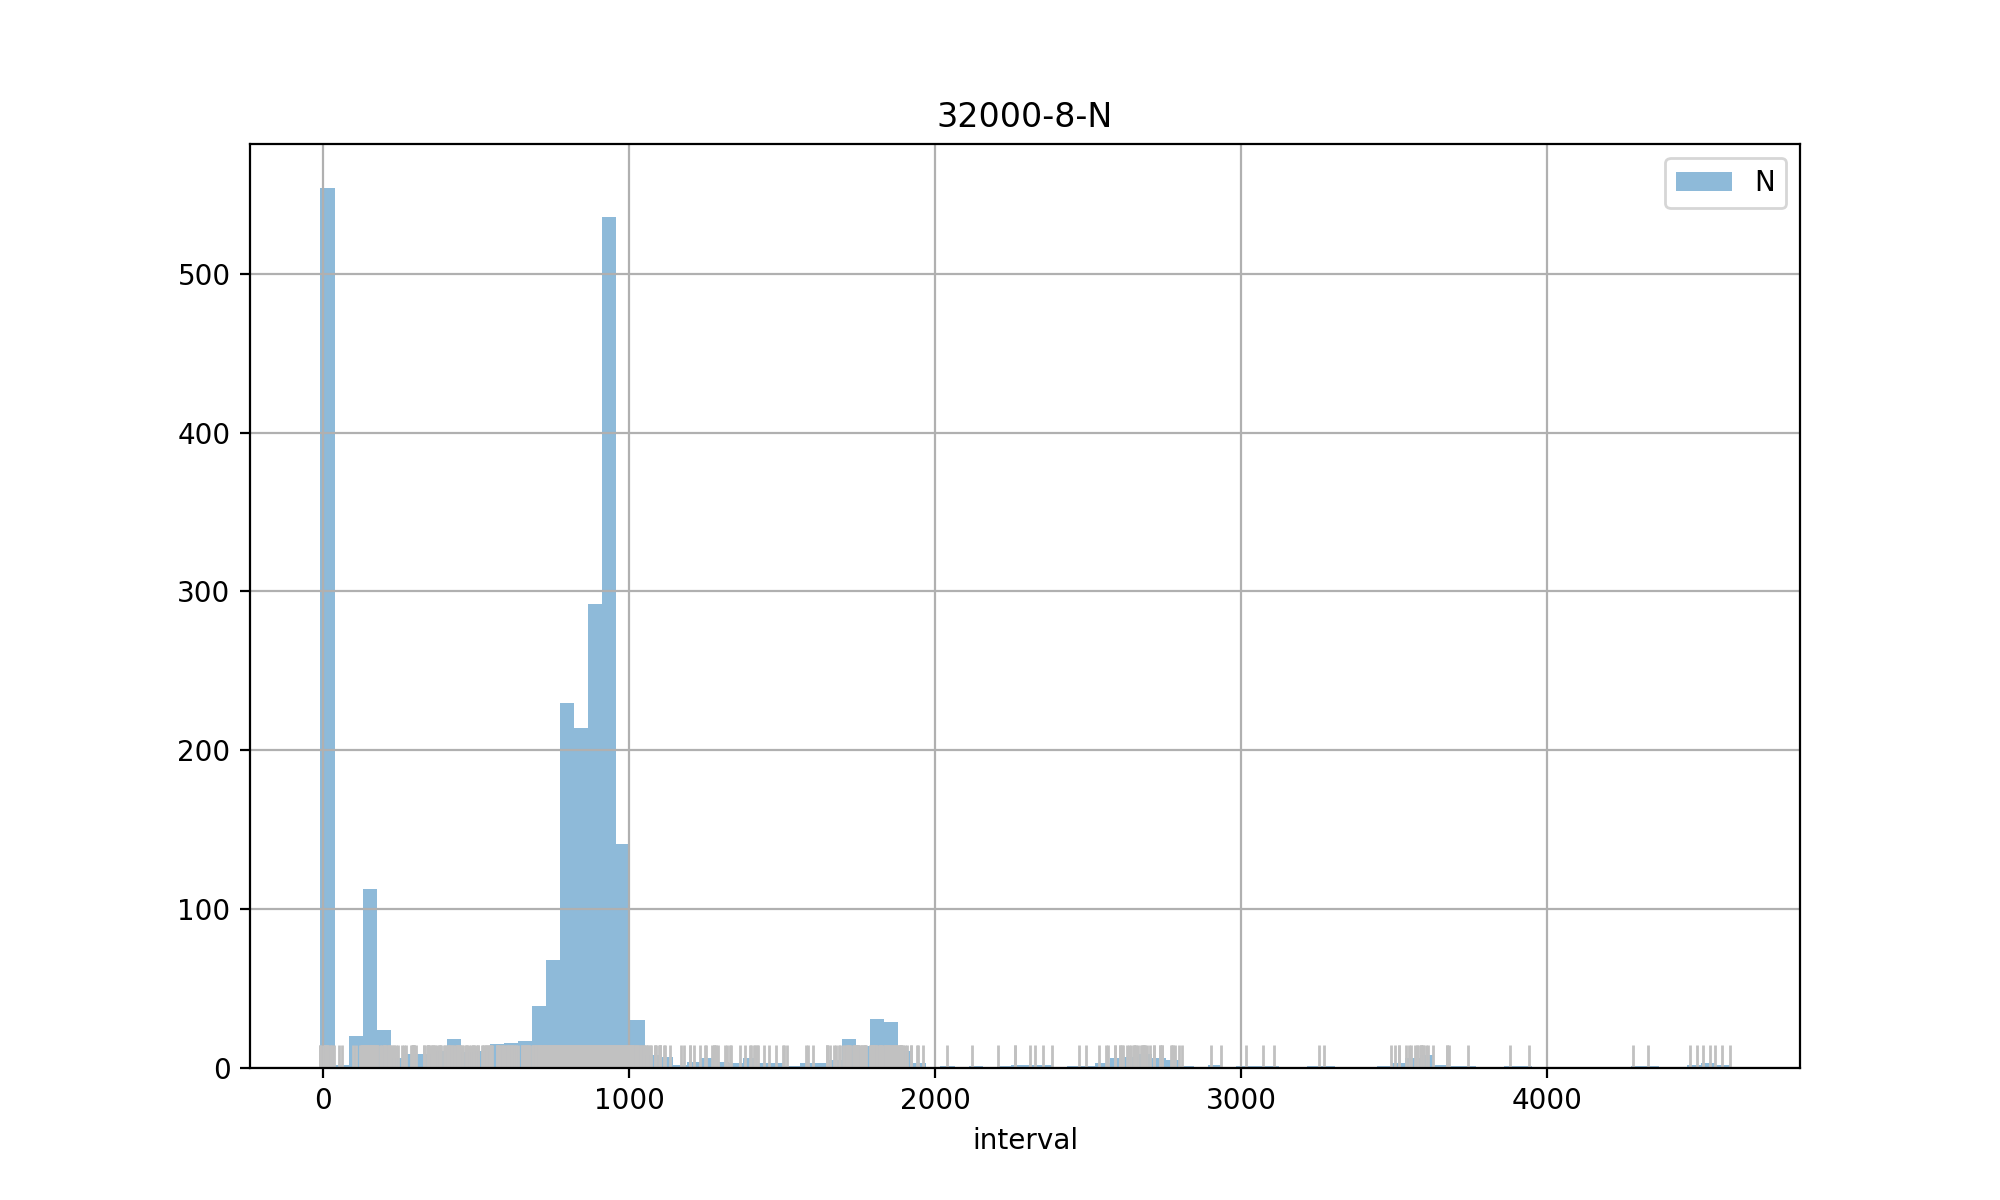

N count    2637.00
mean      759.12
std       638.68
min        -8.00
25%       153.00
50%       852.00
75%       932.00
max      4596.00
Name: interval, dtype: object


<IPython.core.display.Javascript object>


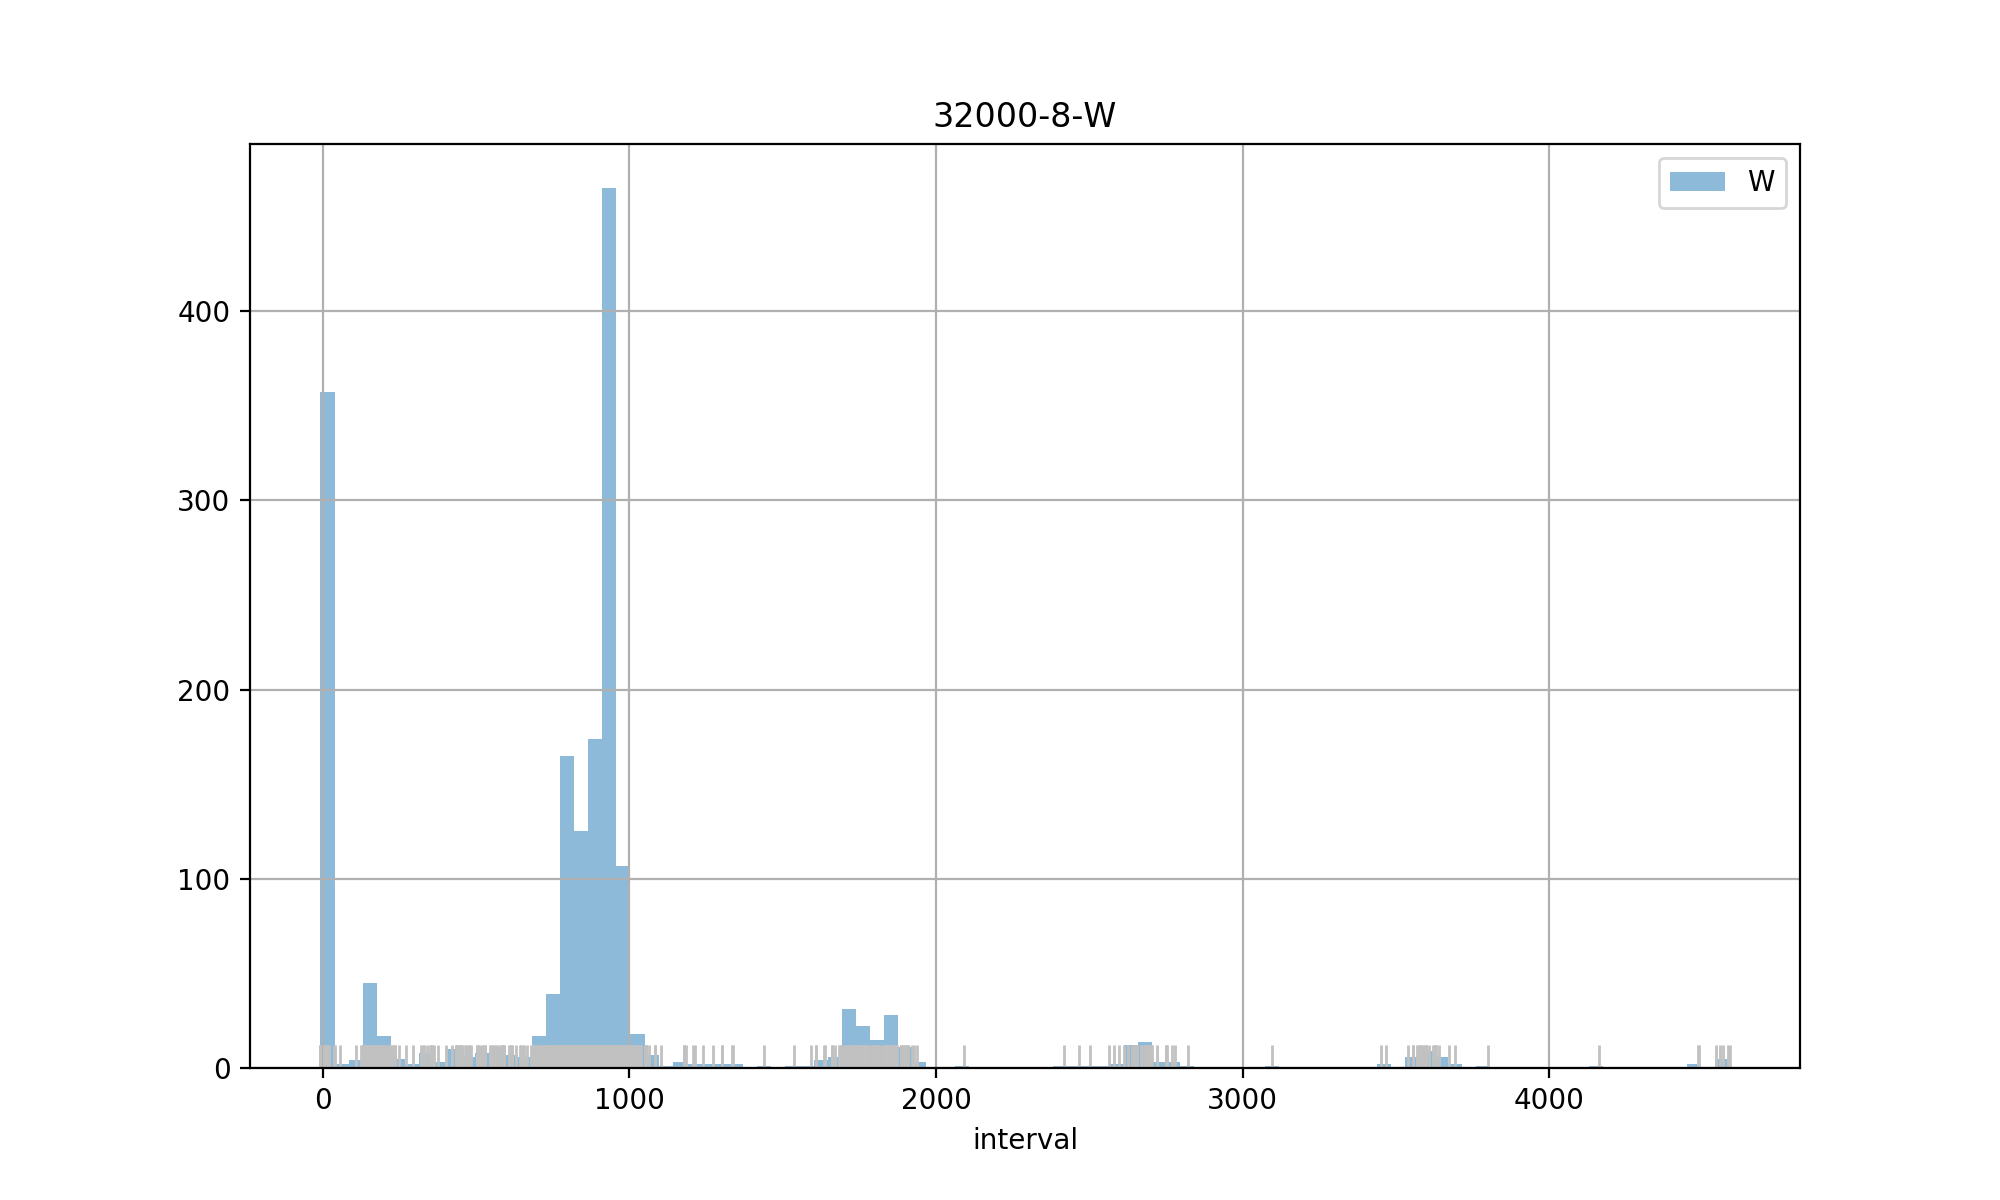

W count    1818.00
mean      833.25
std       684.04
min        -8.00
25%       466.50
50%       889.50
75%       943.00
max      4588.00
Name: interval, dtype: object


In [49]:
# show the slots in separate graphs 
for slot in list('DNW'):
    ddf = trimmed[trimmed.SLOT == slot]
    fig = plt.figure()
    ax = plt.subplot()
    ax.grid(True, which='both')  # set a grid
    fig.set_size_inches(10, 6)   # size of the full figure
    rugkws={"height": .025, "color": "999999"}  # rug display parameters
    histkws={"linewidth": 1, "alpha": 0.5}        # histogram display parameters

    sns.distplot(ddf.interval, label=slot, kde=False, bins=bins_to_use, hist_kws=histkws, rug=True, rug_kws=rugkws)
    # print the basic stats
    print(slot, ddf["interval"].describe().apply(lambda x: format(x, '.2f')))

    plt.title(agency + "-" + slot)    # output the title
    plt.legend()         # display a legend